# Exploration of LIMEtree explanations

In [1]:
import os

_base_path = ('https://raw.githubusercontent.com/fat-forensics/resources/'
              'master/surrogates_overview/scripts/{}')
_scripts = ['__init__.py', 'image_classifier.py', 'imagenet_label_map.py']
! mkdir -p scripts
for i in _scripts:
    i_ = _base_path.format(i)
    if not os.path.exists(f'scripts/{i}'):
        ! wget $i_ -O scripts/$i

! mkdir -p _figures

In [2]:
# NBVAL_IGNORE_OUTPUT
import fatf

import fatf.utils.data.instance_augmentation as fatf_augmentation
import fatf.utils.models.processing as fatf_processing

import fatf.utils.data.segmentation as fatf_segmentation
import fatf.utils.data.occlusion as fatf_occlusion

import scripts.image_classifier as imgclf

from scripts.helpers import plot_bar_exp

from scripts.limetree import (
    imshow, visualise_img,
    tree_to_code, rules_dict2array, rules_dict2list,
    tree_get_explanation, filter_explanations)

22-Sep-01 21:58:30 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [3]:
import itertools

import sklearn.linear_model
import sklearn.tree

from PIL import Image

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('text', usetex=True)
plt.style.use('seaborn')  # 'classic'

In [4]:
IDS = {
    'tennis ball': 852,
    'golden retriever': 207,
    'Labrador retriever': 208
}

def find_dog_prediction(tuple_list):
    classes = tuple(IDS.keys())
    return [i for i in tuple_list if i[0] in classes]

In [5]:
dog = Image.open('img/dog_ball.jpg')
dog_array = np.asarray(dog)

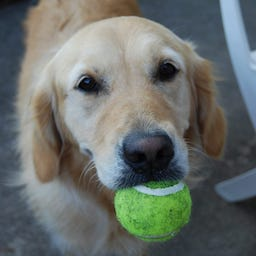

In [6]:
dog

In [7]:
clf = imgclf.ImageClassifier()

clf.proba2tuple(
    clf.predict_proba([dog_array]),
    labels_no=5
)

/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/kacper/.pyenv/versions/3.8.13/envs/limetree/lib/python3.8/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may 

[[('tennis ball', 0.99284875, 852),
  ('golden retriever', 0.0067028664, 207),
  ('Labrador retriever', 0.00043766573, 208),
  ('racket', 4.7027543e-06, 752),
  ('Chesapeake Bay retriever', 2.9818214e-06, 209)]]

## Segmentation

### Default

In [8]:
fatf.setup_random_seed(42)

segmenter = fatf_segmentation.QuickShift(
    dog_array,
    ratio=0.2,      # 0.1
    kernel_size=5,  # 10
    max_dist=50)    # 30

22-Sep-01 21:58:31 fatf         INFO     Seeding RNGs using the input parameter.
22-Sep-01 21:58:31 fatf         INFO     Seeding RNGs with 42.


In [9]:
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 29


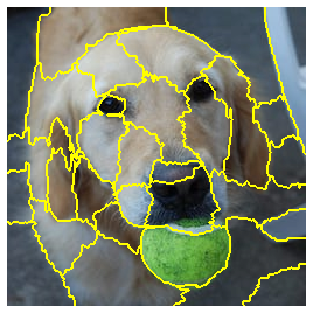

In [10]:
dog_segmented_default = segmenter.mark_boundaries(colour=(255, 255, 0))

imshow(dog_segmented_default)

In [11]:
plt.imsave('_figures/dog_segments_default.jpeg', dog_segmented_default)

### Custom

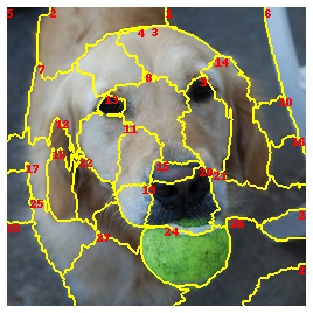

In [12]:
imshow(segmenter.number_segments(
    image=dog_segmented_default, colour=(255, 0, 0)))

In [13]:
# husky_segment_merge = [             # retriever
#     [23],                           # ball
#     [13],                           # left eye
#     [9],                            # right eye
#     [19],                           # nose
#     [18, 11, 8, 3, 14, 5],          # face
#     [0, 2, 7, 17, 24, 26, 21],      # body
#     [4, 12, 16, 27],                # left bg
#     [1, 6, 10, 15, 20, 22, 25, 28]  # right bg
# ]

dog_segment_merge = [               # RETRIEVER
    [24],                           # ball
    [13],                           # left eye
    [9],                            # right eye
    [15, 20],                       # nose
    [3, 4, 8, 11, 14, 19],          # face
    [2, 7, 18, 22, 25, 27],         # body
    [5, 12, 17, 28],                # left bg
    [1, 6, 10, 16, 21, 23, 26, 29]  # right bg
]

_ = segmenter.merge_segments(dog_segment_merge, inplace=True)
segmenter.segments_number = len(dog_segment_merge)
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 8


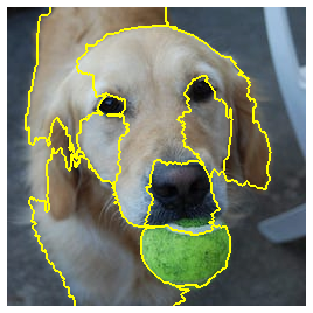

In [14]:
dog_segmented_custom = segmenter.mark_boundaries(colour=(255, 255, 0), )

imshow(dog_segmented_custom)

In [15]:
plt.imsave('_figures/dog_segments_custom.jpeg', dog_segmented_custom)

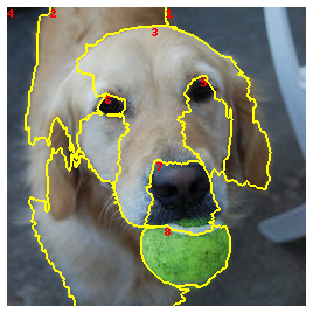

In [16]:
imshow(segmenter.number_segments(
    image=dog_segmented_custom, colour=(255, 0, 0)))

## Surrogate Explanations

In [17]:
SAMPLES_NO = 1000
GENERATE_FULL_SAMPLE = True

BATCH_SIZE = 100

OCCLUSION_COLOUR = 'black'

GET_TOP_N = 4

In [18]:
# Get occluder with the desired colour
occluder = fatf_occlusion.Occlusion(
    dog_array, segmenter.segments, colour=OCCLUSION_COLOUR)

# Generate sample
if GENERATE_FULL_SAMPLE:
    sampled_data = np.array(list(itertools.product(
        [0, 1], repeat=segmenter.segments_number)))
else:
    fatf.setup_random_seed(42)
    sampled_data = fatf_augmentation.random_binary_sampler(
        segmenter.segments_number, SAMPLES_NO)

# Convert to images and predict (in batches)
iter_ = fatf_processing.batch_data(
    sampled_data,
    batch_size=BATCH_SIZE,
    transformation_fn=occluder.occlude_segments_vectorised)

sampled_data_probabilities = []
for batch in iter_:
    sampled_data_probabilities.append(
        clf.predict_proba(batch))
sampled_data_probabilities = np.vstack(sampled_data_probabilities)

## Linear Surrogate Explanation

In [19]:
# Get linear explanation
def get_linear(class_id, top_features=None):
    class_probs = sampled_data_probabilities[:, class_id]

    model = sklearn.linear_model.Ridge(
        alpha=1, fit_intercept=True, random_state=42)
    model.fit(sampled_data, class_probs)  # sample_weight

    feature_ordering = np.flip(np.argsort(np.abs(model.coef_)))
    if top_features is None:
        top_features = feature_ordering
    else:
        top_features = feature_ordering[:top_features]
    # Add 1 since segment count starts at 1 and not at 0
    top_features_ = top_features + 1

    explanation = list(zip(top_features_, model.coef_[top_features]))

    return model, explanation

### Tennis Ball

In [20]:
class_name = 'tennis ball'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(8, 0.5707107618686994),
 (1, 0.1807757013812819),
 (7, 0.14842935371877786),
 (3, 0.1097288713175763),
 (2, 0.09273315175544389),
 (5, -0.04280985697740178),
 (4, 0.0298128960593938),
 (6, 0.00012397692646048272)]

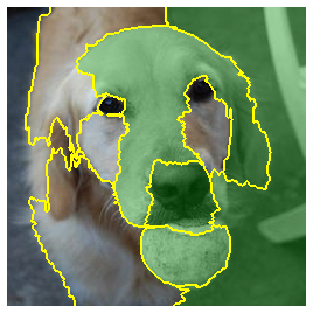

In [21]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

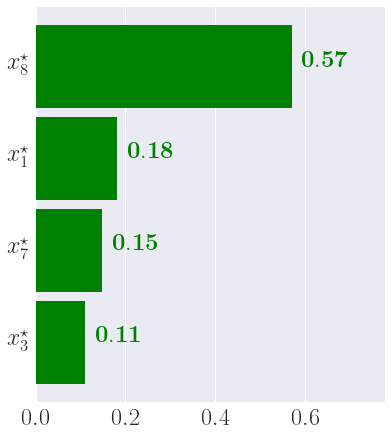

In [22]:
# fontsize=14 # labelsize=16
# xlim = (-0.001, 0.017) # xlim = (-0.01, 0.76)
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

### Golden Retriever

In [23]:
class_name = 'golden retriever'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(3, 0.20141866333716293),
 (8, -0.16662474810102204),
 (2, 0.16273523417896815),
 (4, 0.12128360375618684),
 (5, 0.10404708783272863),
 (7, -0.027010859908332265),
 (6, 0.016954275475991997),
 (1, -0.012462798209654246)]

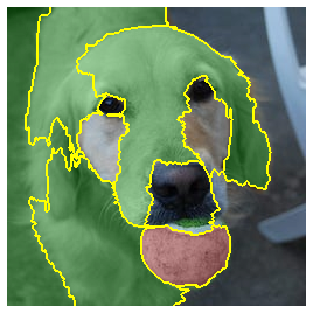

In [24]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

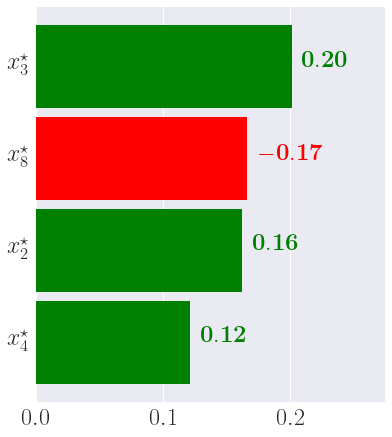

In [25]:
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

### Labrador Retriever

In [26]:
class_name = 'Labrador retriever'
model, explanation = get_linear(IDS[class_name])
explanation_sorted = map(lambda x: x[1], sorted(explanation, key=lambda x: x[0]))

explanation

[(3, 0.15139601134898034),
 (5, 0.12815846643001208),
 (1, -0.09717757483252593),
 (6, 0.07935184095286928),
 (8, -0.07637668257608102),
 (2, -0.055661680635070696),
 (4, -0.02412919704004428),
 (7, 0.019621274000682944)]

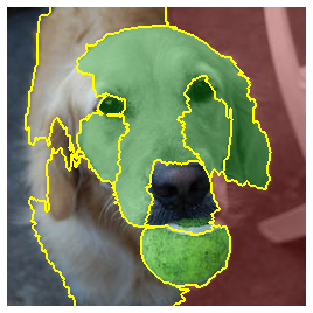

In [27]:
explanation_overlay = visualise_img(explanation, segmenter, top_features=GET_TOP_N)

imshow(explanation_overlay)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_overlay)

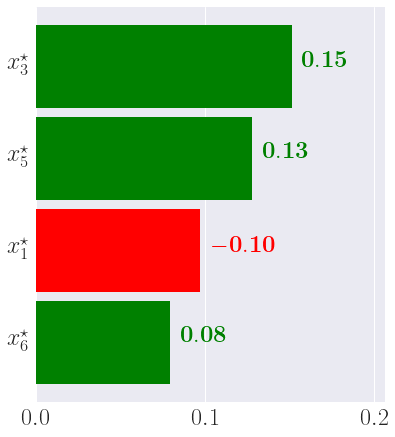

In [28]:
plot_bar_exp(
    explanation_sorted,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf')

## Tree Surrogate Explanation

In [29]:
# Get tree explanation
def get_tree(class_ids, tree_params=None):
    if tree_params is None: tree_params = dict()
    class_probs = sampled_data_probabilities[:, class_ids]

    model = sklearn.tree.DecisionTreeRegressor(random_state=42, **tree_params)
    model.fit(sampled_data, class_probs)  # sample_weight

    return model

In [30]:
classes_sorted = sorted(IDS.items(), key=lambda x: x[1])
classes_names = [i[0] for i in classes_sorted]
classes_ids = [i[1] for i in classes_sorted]

feature_names = [f'\\(x_{{{i+1:d}}}^\star\\)'
                 for i in range(segmenter.segments_number)]
feature_names_ = [f'x{i+1:d}' for i in range(segmenter.segments_number)]

In [31]:
# Full tree
tree_multi = get_tree(classes_ids)

The depth is: 8


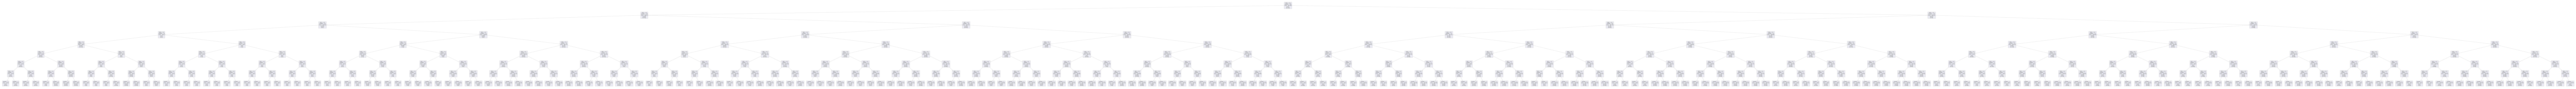

In [32]:
print(f'The depth is: {tree_multi.get_depth()}')

plt.figure(figsize=(512, 18))
_ = sklearn.tree.plot_tree(
    tree_multi,
    fontsize=12,
    # filled=True,
    node_ids=False,
    # label='all',
    impurity=False)

### Tree Visualisation -- Toy Tree

In [33]:
# Toy tree
tree_params = dict(
    # max_leaf_nodes=5,
    max_depth=2,
    # max_leaf_nodes=4,
    # min_impurity_decrease=0.01
)
tree_multi_2 = get_tree(classes_ids, tree_params)

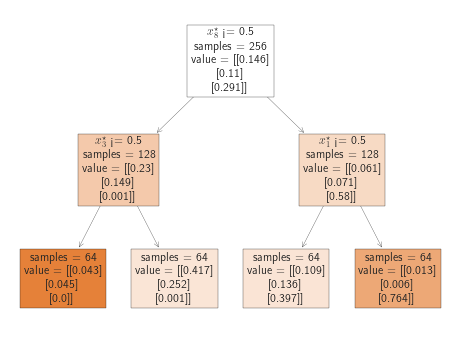

In [34]:
plt.figure(figsize=(8, 6))
_ = sklearn.tree.plot_tree(
    tree_multi_2,
    feature_names=feature_names,
    class_names=classes_names,
    fontsize=12,
    filled=True,
    node_ids=False,
    label='all',
    impurity=False)

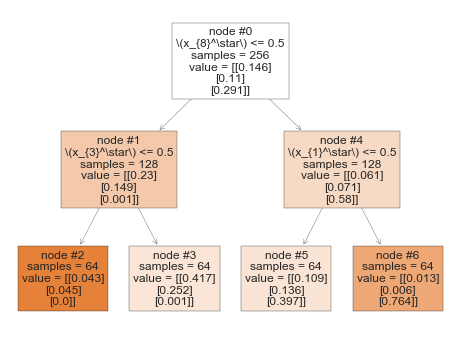

In [35]:
matplotlib.rc('text', usetex=False)
plt.figure(figsize=(8, 6))
_ = sklearn.tree.plot_tree(
    tree_multi_2,
    feature_names=feature_names,
    class_names=classes_names,
    fontsize=12,
    filled=True,
    node_ids=True,
    label='all',
    impurity=False)
matplotlib.rc('text', usetex=True)

In [36]:
tree_to_code(tree_multi_2, feature_names=feature_names_)

{0: {},
 1: {'x8': 0},
 2: {'x8': 0, 'x3': 0, 'prediction': array([[0.04340159],
         [0.04481025],
         [0.00039032]])},
 3: {'x8': 0,
  'x3': 1,
  'prediction': array([[0.41719728],
         [0.25243066],
         [0.00133904]])},
 4: {'x8': 1},
 5: {'x8': 1,
  'x1': 0,
  'prediction': array([[0.10899713],
         [0.13622521],
         [0.39710322]])},
 6: {'x8': 1,
  'x1': 1,
  'prediction': array([[0.01314522],
         [0.00587556],
         [0.76388237]])}}

In [37]:
tree_multi_2_code = tree_to_code(
    tree_multi_2, feature_number=segmenter.segments_number)
tree_multi_2_list = rules_dict2list(
    tree_multi_2_code, segmenter.segments_number)
tree_multi_2_list

{0: {'off': [], 'on': [], 'none': [1, 2, 3, 4, 5, 6, 7, 8]},
 1: {'off': [8], 'on': [], 'none': [1, 2, 3, 4, 5, 6, 7]},
 2: {'off': [8, 3],
  'on': [],
  'none': [1, 2, 4, 5, 6, 7],
  'prediction': array([[0.04340159],
         [0.04481025],
         [0.00039032]])},
 3: {'off': [8],
  'on': [3],
  'none': [1, 2, 4, 5, 6, 7],
  'prediction': array([[0.41719728],
         [0.25243066],
         [0.00133904]])},
 4: {'off': [], 'on': [8], 'none': [1, 2, 3, 4, 5, 6, 7]},
 5: {'off': [1],
  'on': [8],
  'none': [2, 3, 4, 5, 6, 7],
  'prediction': array([[0.10899713],
         [0.13622521],
         [0.39710322]])},
 6: {'off': [],
  'on': [8, 1],
  'none': [2, 3, 4, 5, 6, 7],
  'prediction': array([[0.01314522],
         [0.00587556],
         [0.76388237]])}}

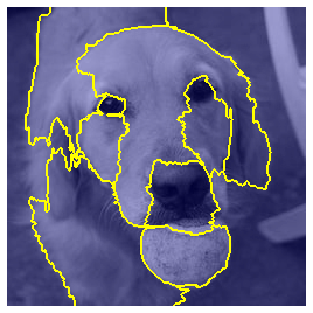

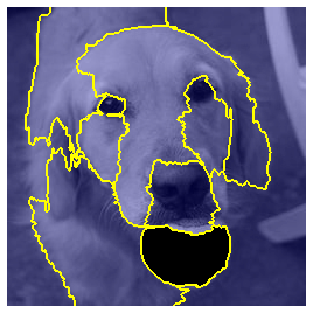

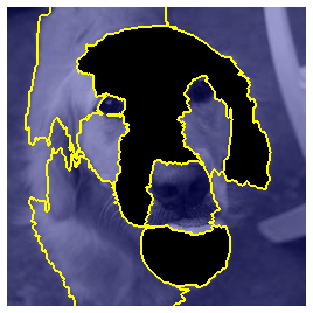

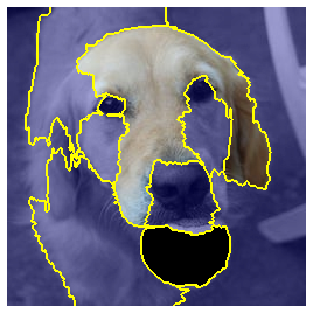

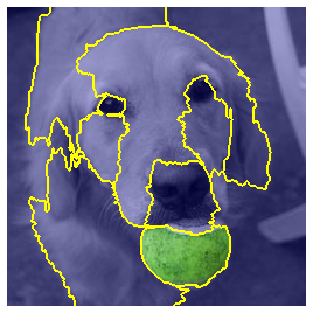

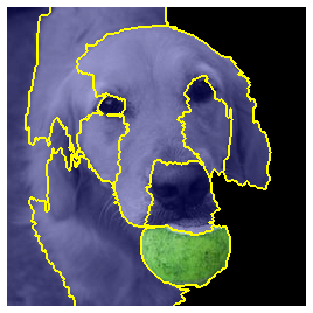

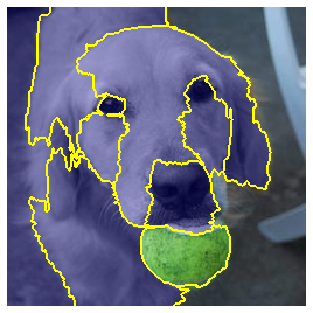

In [38]:
highlight_colours = dict(none=(0, 0, 255), on=None, off=(0, 0, 0))

for node_id, pattern in tree_multi_2_list.items():
    # Highlight none
    node_highlight = segmenter.highlight_segments(
        pattern['none'], colour=highlight_colours['none'])
    # leave on
    # Occlude off
    node_highlight = occluder.occlude_segments(
        pattern['off'], image=node_highlight)
    # highlight boundaries
    node_highlight_ = segmenter.mark_boundaries(
        image=node_highlight, colour=(255, 255, 0))

    imshow(node_highlight_)

    plt.imsave(f'_figures/explanation_limetree_multi-tree-node{node_id}.pdf',  # jpeg
               node_highlight_)

### Feature Importance -- Full Tree

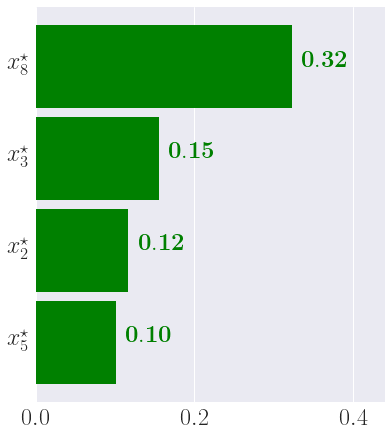

In [39]:
plot_bar_exp(
    tree_multi.feature_importances_,
    feature_no=GET_TOP_N,
    onesided=True,
    start_at_one=True,
    label_fmt='\\(x_{{{:d}}}^\star\\)',
    savepath=f'_figures/explanation_limetree_multi-bar.pdf')

### What-If Explanation -- Full Tree

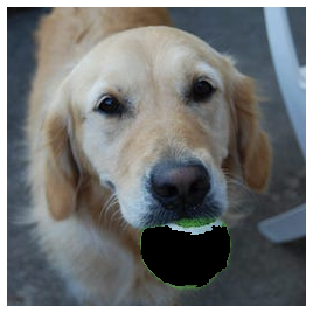

In [40]:
# What if the ball (#8) was not there?
segment_id_ball = 8

dog_sans_ball = occluder.occlude_segments(segment_id_ball)

imshow(dog_sans_ball)

plt.imsave(f'_figures/explanation_limetree_multi-tree_whatif-ball.pdf',  # jpeg
            dog_sans_ball)

In [41]:
clf.proba2tuple(
    clf.predict_proba([dog_sans_ball]),
    labels_no=5
)

[[('golden retriever', 0.97842544, 207),
  ('Labrador retriever', 0.020758115, 208),
  ('tennis ball', 0.00032637388, 852),
  ('dumbbell', 7.377249e-05, 543),
  ('ice lolly', 5.9372687e-05, 929)]]

In [42]:
dog_sans_ball_binary = np.ones(segmenter.segments_number, dtype=np.int16)
dog_sans_ball_binary[segment_id_ball - 1] = 0

list(zip(classes_names,
         tree_multi.predict([dog_sans_ball_binary])[0]))

[('golden retriever', 0.9784252047538757),
 ('Labrador retriever', 0.0207582488656044),
 ('tennis ball', 0.00032637224649079144)]

### Exemplar Explanation (1) -- Full Tree

In [43]:
class_id = 1

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=True,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->Labrador retriever<-
[0.5219873338937759, 0.3985350430011749, 0.70313960313797, 0.5880861282348633, 0.8181930780410767, 0.48044775426387787, 0.6284545063972473, 0.5938081368803978, 0.5464726239442825, 0.6838817894458771, 0.5567736029624939, 0.8109899759292603, 0.8055271692574024, 0.935744434595108, 0.9794849157333374, 0.983858048915863, 0.9751117825508118, 0.8920039534568787, 0.9466085433959961, 0.8373993635177612, 0.6753099039196968, 0.8860297799110413, 0.9288232922554016, 0.8432362675666809, 0.5344541668891907, 0.567512035369873, 0.4098898470401764, 0.42129531502723694, 0.48264364153146744, 0.5577080994844437, 0.4834911525249481, 0.6319250464439392, 0.7587281465530396, 0.5775877237319946, 0.6746119856834412, 0.4805634617805481, 0.9398685693740845, 0.9748465418815613, 0.9048905968666077, 0.5961926579475403, 0.4588149150367826, 0.7938255667686462, 0.9524870812892914, 0.9267042279243469, 0.9782699346542358, 0.6351640522480011, 0.6617390513420105, 0.6085890531539917]


Probability of class ->Labrador retriever<-: 0.892


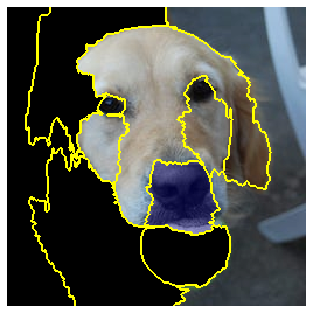

In [44]:
vis_id = 17

print(f'Probability of class ->{classes_names[class_id]}<-: '
      f'{class_prediction[vis_id]:.3f}')

# Highlight none
if image_spec[vis_id]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[vis_id]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[vis_id]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[vis_id]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-example{class_id}.pdf',  # jpeg
            example_highlight_)

### Exemplar Explanation (2) -- Full Tree

In [45]:
class_id = 0

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=True,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->golden retriever<-
[0.4296204745769501, 0.5212118029594421, 0.41719727891834424, 0.5904676839709282, 0.5855008959770203, 0.5133654475212097, 0.6576363444328308, 0.7549213021993637, 0.6022788882255554, 0.5301386117935181, 0.6744191646575928, 0.907563716173172, 0.8899784684181213, 0.9251489639282227, 0.5187460780143738, 0.5788366198539734, 0.6306432367618982, 0.47478006807432394, 0.5039458051323891, 0.49829980731010437, 0.6413211524486542, 0.6772428154945374, 0.605399489402771, 0.6760013364255428, 0.5410715937614441, 0.5354164838790894, 0.5467267036437988, 0.8773657232522964, 0.9030389785766602, 0.9285673499107361, 0.8775106072425842, 0.8516924679279327, 0.8703908920288086, 0.8329940438270569, 0.7865064054494724, 0.6352067484986037, 0.6388639509677887, 0.8865243196487427, 0.9299393445253372, 0.8798893690109253, 0.8094518184661865, 0.9503269195556641, 0.9799893200397491, 0.98011314868927, 0.9798654913902283, 0.937806062400341, 0.8967008888721466, 0.9443562030792236, 0.

Probability of class ->golden retriever<-: 0.755


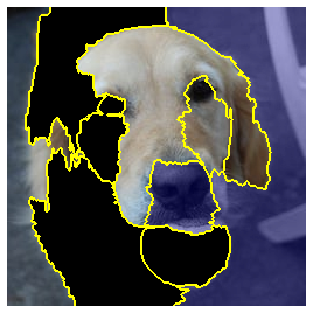

In [46]:
vis_id = 7

print(f'Probability of class ->{classes_names[class_id]}<-: '
      f'{class_prediction[vis_id]:.3f}')

# Highlight none
if image_spec[vis_id]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[vis_id]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[vis_id]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[vis_id]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-example{class_id}.pdf',  # jpeg
            example_highlight_)

### Shortest Explanations (x2?) -- Full Tree

In [47]:
class_id = 2

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=True,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->tennis ball<-
[0.8454488515853882]


Probability of class ->tennis ball<-: 0.845


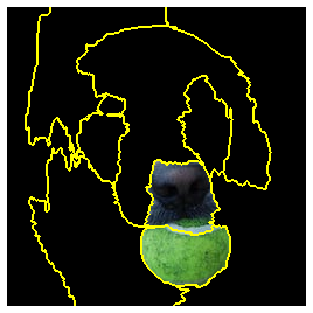

In [48]:
vis_id = 0

print(f'Probability of class ->{classes_names[class_id]}<-: '
      f'{class_prediction[vis_id]:.3f}')

# Highlight none
if image_spec[vis_id]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[vis_id]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[vis_id]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[vis_id]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-shortest{class_id}.pdf',  # jpeg
            example_highlight_)

### Rule Explanation -- Full Tree

In [49]:
class_id = 1

class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=True,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction})')

Explaining class: ->Labrador retriever<- (0.983858048915863)


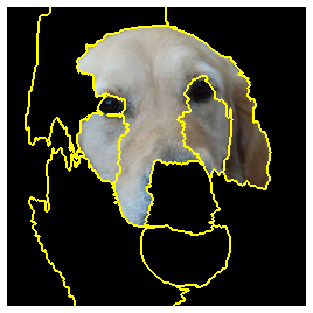

In [50]:
# Highlight none
if image_spec['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec['off']:
    example_highlight = occluder.occlude_segments(
        image_spec['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-rule{class_id}.pdf',  # jpeg
            example_highlight_)

### Customised Explanations x2 -- Full Tree

#### Preserve Ball and Get Golden Retriever

In [51]:
id_on = [segment_id_ball]
id_off = []

class_id = 0

In [52]:
class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->golden retriever<-
[0.5212118029594421, 0.5133654475212097, 0.6576363444328308, 0.5301386117935181, 0.6744191646575928, 0.8899784684181213, 0.9251489639282227, 0.5788366198539734, 0.49829980731010437, 0.6772428154945374, 0.605399489402771, 0.5354164838790894, 0.5467267036437988, 0.9285673499107361, 0.8775106072425842, 0.8703908920288086, 0.8329940438270569, 0.8865243196487427, 0.8094518184661865, 0.9503269195556641, 0.98011314868927, 0.9798654913902283, 0.9614250063896179, 0.9272873997688293, 0.8067657947540283, 0.8913253545761108, 0.9931704998016357, 0.9793546199798584, 0.964694619178772, 0.9784252047538757, 0.5292391777038574, 0.4657517373561859, 0.669413149356842, 0.567509114742279, 0.523370087146759, 0.5353103876113892, 0.5534306168556213, 0.4281335771083832]


In [53]:
on_off_idxs = filter_explanations(
    image_spec, on=id_on, off=id_off, use_none=False)

for i in on_off_idxs:
    print(f'{i}: {class_prediction[i]:.3f}\n    {image_spec[i]}')

30: 0.529
    {'off': [1, 7, 3, 6, 5], 'on': [8, 2, 4], 'none': []}
31: 0.466
    {'off': [1, 7, 3, 6], 'on': [8, 2, 4, 5], 'none': []}
32: 0.669
    {'off': [1, 7, 3, 5], 'on': [8, 2, 4, 6], 'none': []}
33: 0.568
    {'off': [1, 7, 3], 'on': [8, 2, 4, 6, 5], 'none': []}
34: 0.523
    {'off': [1, 7, 6], 'on': [8, 2, 3, 5, 4], 'none': []}
35: 0.535
    {'off': [1, 7], 'on': [8, 2, 3, 5, 4, 6], 'none': []}
36: 0.553
    {'off': [1, 5], 'on': [8, 7, 3, 2, 4, 6], 'none': []}
37: 0.428
    {'off': [1, 6], 'on': [8, 7, 5, 3, 2, 4], 'none': []}


In [54]:
# Get argmax
idx = np.argmax([class_prediction[i] for i in on_off_idxs])
idx = on_off_idxs[idx]

class_prediction = class_prediction[idx]
image_spec = image_spec[idx]

Explaining class: ->golden retriever<- (0.669413149356842)


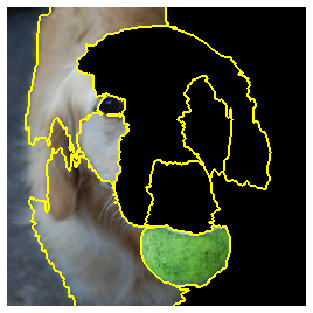

In [55]:
print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction})')

# Highlight none
if image_spec['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec['off']:
    example_highlight = occluder.occlude_segments(
        image_spec['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-custom{class_id}.pdf',  # jpeg
            example_highlight_)

#### Preserve Ball and Get Golden Retriever

In [56]:
id_on = []
id_off = [segment_id_ball]

class_id = 2

In [57]:
class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=False,
    discard_others=False)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->tennis ball<-
[0.9920810461044312, 0.9995005130767822, 0.9436565041542053, 0.6765637993812561, 0.6057499051094055, 0.7226921916007996, 0.8454488515853882, 0.9571712017059326, 0.9625731110572815, 0.9245413541793823, 0.5934405326843262, 0.6982890367507935, 0.9328508377075195, 0.6928161382675171, 0.7909379601478577, 0.9050533175468445, 0.8229256868362427, 0.8437155485153198, 0.8113393783569336, 0.6110810041427612, 0.8730183243751526, 0.5822265148162842, 0.5983362197875977, 0.9008616805076599, 0.7939490079879761, 0.6475099325180054, 0.9421596527099609, 0.8150218725204468, 0.6921080350875854, 0.9883113503456116, 0.9535269737243652, 0.9356293678283691, 0.8235605955123901, 0.725173830986023, 0.833906888961792, 0.9898126721382141, 0.9123557806015015, 0.9961066842079163, 0.6615800857543945, 0.9394376277923584, 0.9668198823928833, 0.864931046962738, 0.7239133715629578, 0.9420244693756104, 0.9711381793022156, 0.8800623416900635, 0.5534337759017944, 0.8879333138465881, 0.873818

In [58]:
on_off_idxs = filter_explanations(
    image_spec, on=id_on, off=id_off, use_none=False)

for i in on_off_idxs:
    print(f'{i}: {class_prediction[i]:.3f}\n    {image_spec[i]}')

In [59]:
class_prediction, image_spec = tree_get_explanation(
    tree_multi,
    class_id,
    feature_number=segmenter.segments_number,
    include_split_nodes=False,
    max_pred=False,
    max_occlusion=False,
    discard_others=True)

print(f'Explaining class: ->{classes_names[class_id]}<-')
print(class_prediction)

Explaining class: ->tennis ball<-
[0.001499425619840622, 0.001113596372306347, 0.0008099061087705195, 0.0012116151629015803, 0.00037587591214105487, 0.0010913447476923466, 0.0003672103339340538, 0.00014249644300434738, 0.0002992873196490109, 0.0007091103470884264, 0.0003440854779910296, 9.520944877294824e-05, 0.00010561379895079881, 7.62615745770745e-05, 9.945179954229388e-06, 0.001348754856735468, 0.007794979028403759, 0.010640124790370464, 0.024162381887435913, 0.03275640681385994, 0.018414288759231567, 0.2878204882144928, 0.0910262018442154, 0.034550346434116364, 0.02138107270002365, 0.05043340474367142, 0.14510636031627655, 0.0026964026037603617, 0.0038337043952196836, 0.014160934835672379, 0.008111252449452877, 0.9920810461044312, 0.9995005130767822, 0.9436565041542053, 0.6765637993812561, 0.6057499051094055, 0.7226921916007996, 0.8454488515853882, 0.9571712017059326, 0.9625731110572815, 0.9245413541793823, 0.5934405326843262, 0.6982890367507935, 0.9328508377075195, 0.692816138267

In [60]:
on_off_idxs = filter_explanations(
    image_spec, on=id_on, off=id_off, use_none=False)

for i in on_off_idxs:
    print(f'{i}: {class_prediction[i]:.3f}\n    {image_spec[i]}')

0: 0.001
    {'off': [8, 3, 2, 1, 5, 7, 6, 4], 'on': [], 'none': []}
1: 0.001
    {'off': [8, 3, 2, 1, 5, 7, 6], 'on': [4], 'none': []}
2: 0.001
    {'off': [8, 3, 2, 1, 5, 7, 4], 'on': [6], 'none': []}
3: 0.001
    {'off': [8, 3, 2, 1, 5, 7], 'on': [6, 4], 'none': []}
4: 0.000
    {'off': [8, 3, 2, 1, 5, 6, 4], 'on': [7], 'none': []}
5: 0.001
    {'off': [8, 3, 2, 1, 5, 6], 'on': [7, 4], 'none': []}
6: 0.000
    {'off': [8, 3, 2, 1, 6, 4, 7], 'on': [5], 'none': []}
7: 0.000
    {'off': [8, 3, 2, 1, 6, 4], 'on': [5, 7], 'none': []}
8: 0.000
    {'off': [8, 3, 2, 1, 6, 7], 'on': [5, 4], 'none': []}
9: 0.001
    {'off': [8, 3, 2, 1, 6], 'on': [5, 4, 7], 'none': []}
10: 0.000
    {'off': [8, 3, 2, 7, 4, 6], 'on': [1, 5], 'none': []}
11: 0.000
    {'off': [8, 3, 2, 7, 4], 'on': [1, 5, 6], 'none': []}
12: 0.000
    {'off': [8, 3, 4, 6, 7, 5, 1], 'on': [2], 'none': []}
13: 0.000
    {'off': [8, 3, 4, 6, 7, 1], 'on': [2, 5], 'none': []}
14: 0.000
    {'off': [8, 3, 4, 6, 7], 'on': [2, 5, 1], 

In [61]:
# Get argmax
idx = np.argmax([class_prediction[i] for i in on_off_idxs])
idx = on_off_idxs[idx]

Explaining class: ->tennis ball<- (0.001499425619840622)
[[('jellyfish', 0.012172587, 107), ('Granny Smith', 0.011299615, 948), ('sax', 0.01011972, 776), ("jack-o'-lantern", 0.009103122, 607), ('ear', 0.0068591405, 998)]]


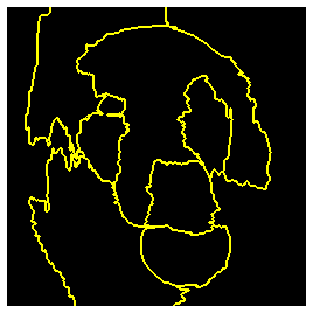

In [62]:
print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction[idx]})')

# Highlight none
if image_spec[idx]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[idx]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[idx]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[idx]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

print(clf.proba2tuple(
    clf.predict_proba([example_highlight]),
    labels_no=5
))

imshow(example_highlight_)

In [63]:
# Sort on probability
idxs = np.argsort([class_prediction[i] for i in on_off_idxs])

class_prediction = [class_prediction[i] for i in idxs]
image_spec = [image_spec[i] for i in idxs]

Explaining class: ->tennis ball<- (0.0012116151629015803)
[[('projectile', 0.101536304, 744), ('missile', 0.07973264, 657), ('miniskirt', 0.051802948, 655), ('volcano', 0.02546557, 980), ('diaper', 0.01903055, 529)]]


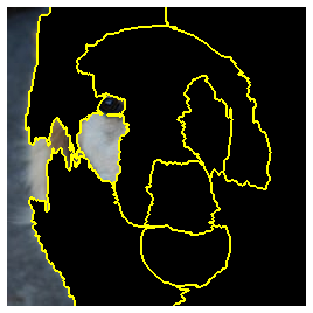

In [64]:
idx = idxs[1]

print(f'Explaining class: ->{classes_names[class_id]}<- ({class_prediction[idx]})')

# Highlight none
if image_spec[idx]['none']:
    example_highlight = segmenter.highlight_segments(
        image_spec[idx]['none'], colour=highlight_colours['none'])
else:
    example_highlight = segmenter.image.copy()
# leave on
# Occlude off
if image_spec[idx]['off']:
    example_highlight = occluder.occlude_segments(
        image_spec[idx]['off'], image=example_highlight)
else:
    example_highlight = example_highlight
# highlight boundaries
example_highlight_ = segmenter.mark_boundaries(
    image=example_highlight, colour=(255, 255, 0))

print(clf.proba2tuple(
    clf.predict_proba([example_highlight]),
    labels_no=5
))

imshow(example_highlight_)

plt.imsave(f'_figures/explanation_limetree_multi-tree-custom{class_id}.pdf',  # jpeg
            example_highlight_)